# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
7289,12650,57602,"Brisbane, Queensland",20-03-2020,@sallymcmanus @SwannyQLD @AWUnion @MaritimeUni...,Positive
20308,28569,73521,"Vashon Island, WA",27-03-2020,No seriously H E B knew amp prepared themselve...,Negative
22892,31774,76726,NaN,04-04-2020,3 Today I am directing the Malawi Energy Regul...,Positive
19166,27127,72079,NaN,26-03-2020,koko pimentel went to a hospital birthday part...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
# -- YOUR CODE HERE --
df.loc[(df['Sentiment'] == 'Positive') | (df['Sentiment'] == 'Extremely Positive'), 'Sentiment'] = 1
df.loc[(df['Sentiment'] == 'Negative') | (df['Sentiment'] == 'Extremely Negative'), 'Sentiment'] = 0

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [ ]:
# -- YOUR CODE HERE --
print(f"positive: {df['Sentiment'].sum()}")
print(f"negative: {df['Sentiment'].shape[0] - df['Sentiment'].sum()}")

positive: 18046
negative: 15398


**Ответ:** Классы отличаются совсем немного, принято решение не добавлять еще элементы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
# -- YOUR CODE HERE --
df.isna().any()

UserName         False
ScreenName       False
Location          True
TweetAt          False
OriginalTweet    False
Sentiment        False
dtype: bool

In [ ]:
df.fillna("Unknown", inplace=True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.7, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
# -- YOUR CODE HERE --
from collections import Counter

text = ''.join(train['OriginalTweet']).lower()
d = Counter(text.split())

Какой размер словаря получился?

In [ ]:
# -- YOUR CODE HERE --
len(d)

86999

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
# -- YOUR CODE HERE --
sorted_tokens = sorted(d.items(), key=lambda x: x[1], reverse=True)
sorted_tokens[:10]

[('the', 25775),
 ('to', 23217),
 ('and', 14626),
 ('of', 12973),
 ('a', 11406),
 ('in', 10898),
 ('for', 8436),
 ('is', 7280),
 ('are', 6980),
 ('#coronavirus', 6761)]

**Ответ:** Самые часто повторяемые токены - это глаголы is are, предлоги и артикли, оно и не удивительно, их мы употребляем в речи больше всего и именно их фильтруют при обработке текста. Также популярен токен короновируса, так как это была популярная тема для обсуждения, захватившая весь мир

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords

# -- YOUR CODE HERE --
nltk.download("stopwords", quiet=True)

filtered_tokens = [word for word in sorted_tokens if word[0] not in stopwords.words("english")]
filtered_tokens[:10]

[('#coronavirus', 6761),
 ('prices', 3767),
 ('food', 3677),
 ('grocery', 3350),
 ('supermarket', 3181),
 ('store', 3123),
 ('people', 3033),
 ('covid-19', 2984),
 ('&amp;', 2313),
 ('#covid19', 2214)]

**Ответ:**  Сразу несколько позиций занимает ковид, затем все, что связано с продуктами и магазинами, было ммного паники вокруг нехватки продуктов и путсых полок в магазинах, это волновало людей в то время. Еще есть html символ &amp, который неплохо бы исключить

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
# -- YOUR CODE HERE --
filtered_tokens[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqsan', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgzvile', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!just', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Самые непопулярные токены - это слипшиеся со знаками препинания слова, какие-то ссылки и теги аккаунтов. Также есть какие-то редкие слова. Дополнительно работать с ними особого смысла нет


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

# -- YOUR CODE HERE --
tw = TweetTokenizer()
vector = Counter(tw.tokenize(text))

In [ ]:
sorted_tweets = sorted(vector.items(), key=lambda x: x[1], reverse=True)
sorted_tweets[:10]

[('the', 25991),
 ('to', 23329),
 ('.', 23269),
 (',', 17571),
 ('and', 14768),
 ('of', 13008),
 ('a', 11582),
 ('in', 11052),
 ('?', 9477),
 ('for', 8505)]

**Ответ:** в этот раз в массиве есть знаки препинания. Изменения произошли, так как этот токенайзер обрабатывает слова по-своему

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

# -- YOUR CODE HERE --
filtered_tweets = [word for word in sorted_tweets if word[0] not in stopwords.words("english") + list(punctuation)]
filtered_tweets[:10]

[('#coronavirus', 7643),
 ('â', 7214),
 ('\x82', 7113),
 ('19', 6549),
 ('covid', 5891),
 ('prices', 4470),
 ('\x92', 4252),
 ('food', 4222),
 ('store', 3846),
 ('supermarket', 3700)]

**Ответ:** да, есть странные симолы \x92, цифры

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
# -- YOUR CODE HERE --
final_tweets = [word for word in filtered_tweets if len(word[0]) != 1 or ord(word[0]) < 128]

In [ ]:
print("Top 10 most popular:")
print(final_tweets[:10])
print()
print("Top 10 most unpopular:")
print(final_tweets[-10:])

Top 10 most popular:
[('#coronavirus', 7643), ('19', 6549), ('covid', 5891), ('prices', 4470), ('food', 4222), ('store', 3846), ('supermarket', 3700), ('grocery', 3414), ('people', 3324), ('#covid19', 2392)]

Top 10 most unpopular:
[('https://t.co/iaek4fwsgzvile', 1), ('premiership', 1), ('non-playing', 1), ('subsidise', 1), ('playersã', 1), ('renewing', 1), ('flew', 1), ('@torontopearson', 1), ('@680news', 1), ('https://t.co/7j2y3rsld9', 1)]


**Ответ:** Больше нет знака &amp, в остальном все также. В топ 10 самых непопулярных теперь нет странных символов, больше нормальных слов, в остальном остались ссылки и теги

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
# -- YOUR CODE HERE --
[word for word in final_tweets if word[0][0] == "#"][:10]

[('#coronavirus', 7643),
 ('#covid19', 2392),
 ('#covid_19', 1449),
 ('#covid2019', 763),
 ('#toiletpaper', 706),
 ('#covid', 621),
 ('#socialdistancing', 404),
 ('#coronacrisis', 336),
 ('#pandemic', 242),
 ('#coronaviruspandemic', 226)]

**Ответ:** Все они связаны с короновирусом и пандемией

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
# -- YOUR CODE HERE --
[word for word in final_tweets if "https://t.co" in word[0]][:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/aziqcdgrnn', 3),
 ('https://t.co/bylqxrjmnt', 3),
 ('https://t.co/wuieefsnoj', 3)]

**Ответ:** Ссылок по сравнению с хештегами крайне мало, информация о ссылке вряд ли будет полезна

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  # -- YOUR CODE HERE --
  text = text.lower()
  stop = list(punctuation) + stopwords.words("english")
  tokens = [
      word
      for word in TweetTokenizer().tokenize(text)
      if word not in stop and
      (len(word) != 1 or ord(word) < 128) and
      not word.startswith("https://t.co")
  ]



  return tokens


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...,1
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...,1
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,1
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...,0
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh...",1
...,...,...,...,...,...,...
20757,29120,74072,Unknown,31-03-2020,Football is in ruins right now.When it will re...,0
32103,43291,88243,"Waterville, Ireland Austin, TX",13-04-2020,Hand sanitizer made here on the Skellig Coast!...,1
30403,41159,86111,"Mumbai , Delhi India",10-04-2020,An initiative taken by our @GOLDENINITIATI1 ...,1
21243,29702,74654,Unknown,01-04-2020,Vile premiership players demanding full wages ...,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


45308


**Ответ:** Размер уменьшился почти в два раза с прошлого раза

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
tweet, sentiment = train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']
tweet, sentiment

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
# -- YOUR CODE HERE --
X = cv.transform([tweet])

print(f"max token: {cv.get_feature_names_out()[X.toarray().argmax()]}")
a = X.toarray()
a[a == 0] = 100
print(f"min token: {cv.get_feature_names_out()[a.argmin()]}")

max token: #coronavirusoutbreak
min token: #coronavirusoutbreak


**Ответ:** Токены определились не очень хорошо, так как минимальный и максимальный совпадают. Чтобы лучше отразить важность слова для конкретного текста, нужно использовать tf-idf. Так как коронавирус присутствует почти во всех твиттах, то его важность для данного текста будет мала и не должна сильно учитываться

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
# -- YOUR CODE HERE --
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf.fit(train['OriginalTweet'])

TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x7d6438194160>)

In [ ]:
X_tf = tfidf.transform([tweet])

print(f"max token: {tfidf.get_feature_names_out()[X_tf.toarray().argmax()]}")
a = X_tf.toarray()
a[a == 0] = 100
print(f"min token: {tfidf.get_feature_names_out()[a.argmin()]}")

max token: brainless
min token: food


**Ответ:** В этот раз, из-за использования tf-idf, лучше выделились слова, встечающиеся во всех текстах. Мы видим, что наиболее важным оказалось слово brainless, а наименее - слово food. Интуиция здесь в том, что при больших значениях tf-idf слово важно для данного текста, но не так важно для всего набора текстов

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [ ]:
# -- YOUR CODE HERE --
positive_text = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].iloc[3]['OriginalTweet']
print(positive_text)
print("===========")
P = tfidf.transform([positive_text])
print(f"max token: {tfidf.get_feature_names_out()[P.toarray().argmax()]}")

Massive thanks to @waitrose for my delivery of my online food shopping, you two delivery drivers were amazing &amp; excellent customer service skills, not sure why I stopped having you delivery my shopping, I will be having you deliver every week once I can once #coronavirus is over
max token: delivery


In [ ]:
positive_text = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].iloc[6]['OriginalTweet']
print(positive_text)
print("===========")
P = tfidf.transform([positive_text])
print(f"max token: {tfidf.get_feature_names_out()[P.toarray().argmax()]}")



https://t.co/Zp5FNrcPLy #ParkWestVillage #BetterTogether https://t.co/NP318A2Gkn
max token: #parkwestvillage


**Ответ:** Слова с наибольшем значением в tf-idf будут иметь наибольшее значение именно для этого текста. В первом примере выделено слово доставка, что является центральной темой сообщения - похвала за доставку. Тоже самое можно увидеть и во втором примере с деревней.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
# -- YOUR CODE HERE --
cv = CountVectorizer(tokenizer=custom_tokenizer)
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

X_cv_train = cv.fit_transform(train['OriginalTweet'])#.toarray()
X_tfidf_train = tfidf.fit_transform(train['OriginalTweet'])#.toarray()
y_train = train['Sentiment']

X_cv_test = cv.transform(test['OriginalTweet'])#.toarray()
X_tfidf_test = tfidf.transform(test['OriginalTweet'])#.toarray()
y_test = test['Sentiment']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr1 = LogisticRegression(max_iter=199)
lr2 = LogisticRegression(max_iter=199)

lr1.fit(X_cv_train, y_train)
lr2.fit(X_tfidf_train, y_train)

print()
print(f"train cv accuracy: {accuracy_score(y_train, lr1.predict(X_cv_train))}")
print(f"train tf-idf accuracy: {accuracy_score(y_train, lr2.predict(X_tfidf_train))}")
print("=======")

y_cv_predict = lr1.predict(X_cv_test)
y_tfidf_predict = lr2.predict(X_tfidf_test)

print(f"test cv accuracy: {accuracy_score(y_test, lr1.predict(X_cv_test))}")
print(f"test tf-idf accuracy: {accuracy_score(y_test, lr2.predict(X_tfidf_test))}")


train cv accuracy: 0.9844510892780863
train tf-idf accuracy: 0.9254592054677488
test cv accuracy: 0.8672513454255532
test tf-idf accuracy: 0.8533984452860275


**Ответ:** При обучении лучшее значение показала модель, которая использовала обычный векторайзер. Это звучит пардоксально, но видимо эмоциональная окраска текста лучше определяется с помощью простого векторайзера. На тесте значения получились примерно одинковыми

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  # -- YOUR CODE HERE --
  stemmer = SnowballStemmer("english")
  text = text.lower()
  stop = set(punctuation).union(set(stopwords.words("english")))
  tokens = [
      stemmer.stem(word)
      for word in TweetTokenizer().tokenize(text)
      if word not in stop and
      (len(word) != 1 or ord(word) < 128) and
      not word.startswith("https://t.co")
  ]

  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


36652

**Ответ** Словарь уменьшился почти на 10 000 слов. Это может значительно помочь при обучении

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_cv_train = cv.fit_transform(train['OriginalTweet'])#.toarray()
X_tfidf_train = tfidf.fit_transform(train['OriginalTweet'])#.toarray()
y_train = train['Sentiment']

X_cv_test = cv.transform(test['OriginalTweet'])#.toarray()
X_tfidf_test = tfidf.transform(test['OriginalTweet'])#.toarray()
y_test = test['Sentiment']

In [ ]:
# -- YOUR CODE HERE --
lr1 = LogisticRegression(max_iter=200)
lr2 = LogisticRegression(max_iter=200)

lr1.fit(X_cv_train, y_train)
lr2.fit(X_tfidf_train, y_train)

print()
print(f"train cv accuracy: {accuracy_score(y_train, lr1.predict(X_cv_train))}")
print(f"train tf-idf accuracy: {accuracy_score(y_train, lr2.predict(X_tfidf_train))}")
print("=======")

y_cv_predict = lr1.predict(X_cv_test)
y_tfidf_predict = lr2.predict(X_tfidf_test)

print(f"test cv accuracy: {accuracy_score(y_test, lr1.predict(X_cv_test))}")
print(f"test tf-idf accuracy: {accuracy_score(y_test, lr2.predict(X_tfidf_test))}")


train cv accuracy: 0.9718923536950022
train tf-idf accuracy: 0.9158906450234943
test cv accuracy: 0.8672513454255532
test tf-idf accuracy: 0.8560892963922663


**Ответ:** Заметно небольшое ухудшение в рузельтатх, но в общем результат не изменился

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=595
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36551


In [ ]:
# -- YOUR CODE HERE --

**Ответ:** В текстах много слов, которые встречаются во многих текстах и при увеличении этого параметра мы сокращаем число слов, которые есть почти во всех текстах

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00045
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
X_train = cv_df.transform(train['OriginalTweet'])
X_test = cv_df.transform(test['OriginalTweet'])

lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, lr.predict(X_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr.predict(X_test))}")

train accuracy: 0.9286629645450662
test accuracy: 0.8680486346422165


**Ответ:** слова, которые содержаться меньше чем в 0.045% текстов, результаты остались те же.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler
# -- YOUR CODE HERE --
scaler = StandardScaler()
X_tr = X_train.toarray()
X_ts = X_test.toarray()

scaled_train = scaler.fit_transform(X_tr)
scaled_test = scaler.transform(X_ts)

lr = LogisticRegression(max_iter=200)

lr.fit(scaled_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, lr.predict(scaled_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr.predict(scaled_test))}")


train accuracy: 0.9416915847928236
test accuracy: 0.8446282639027307


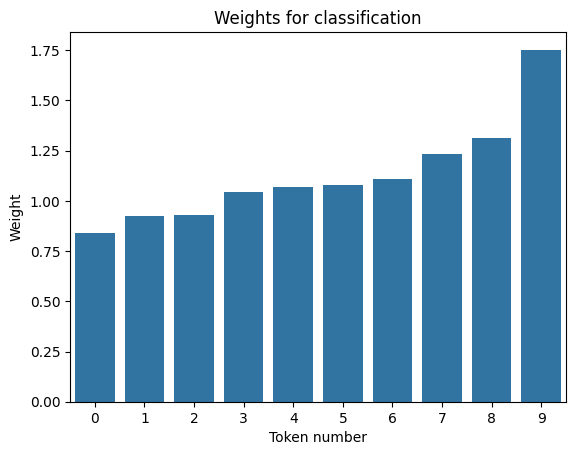

In [ ]:
sns.barplot(np.absolute(lr.coef_[0])[(np.absolute(lr.coef_[0])).argsort()[-10:]])
plt.xlabel('Token number')
plt.ylabel('Weight')

plt.title('Weights for classification');

**Ответ:** Скорее всего, токены с наибольшими весами играют наибольшую роль в классификации

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --
print(f"Uername - unique: {df['UserName'].unique().shape[0]} vs all: {df['UserName'].shape[0]}")
print(f"ScreenName - unique: {df['ScreenName'].unique().shape[0]} vs all: {df['ScreenName'].shape[0]}")

Uername - unique: 33444 vs all: 33444
ScreenName - unique: 33444 vs all: 33444


**Ответ:** Нет смысла добавлять к признакам номера имен, они не несут содержательной ценности

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
X_train.shape

(23410, 3700)

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format="%d-%m-%Y")
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format="%d-%m-%Y")

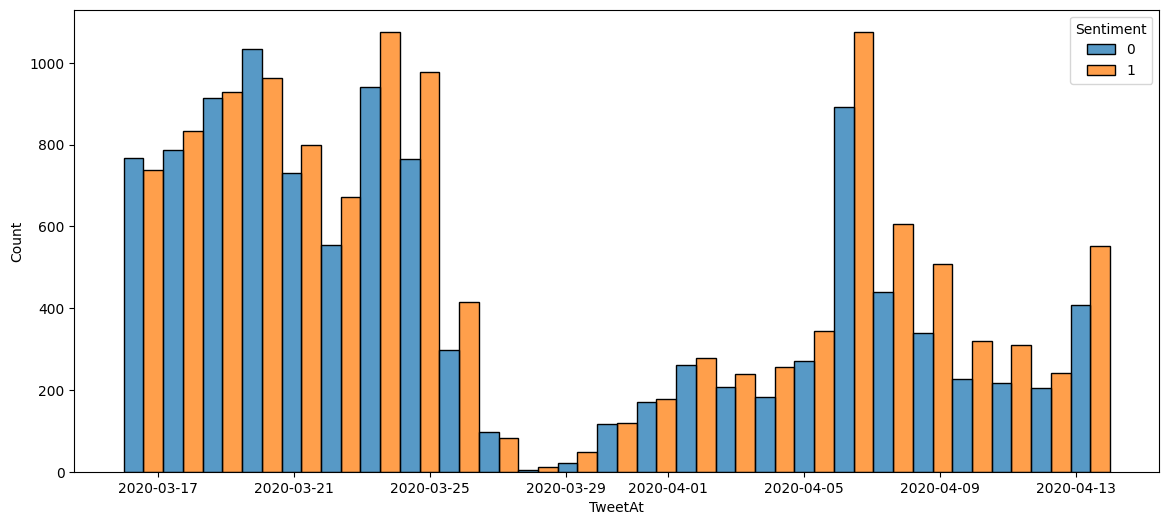

In [ ]:
# -- YOUR CODE HERE --
plt.figure(figsize=(14, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', multiple='dodge');

In [ ]:
train_date_encoded = train['TweetAt'].apply(lambda x: x.year * 10000 + x.month * 100 + x.day)
test_date_encoded = test['TweetAt'].apply(lambda x: x.year * 10000 + x.month * 100 + x.day)

In [ ]:
train_date_encoded.shape

(23410,)

In [ ]:
scaled_train.shape

(23410, 3700)

In [ ]:
scaled_train = np.append(scaled_train, train_date_encoded.to_numpy().reshape((23410, 1)), axis=1)

In [ ]:
scaled_test = np.append(scaled_test, test_date_encoded.to_numpy().reshape((scaled_test.shape[0], 1)), axis=1)

In [ ]:
lr_with_date = LogisticRegression(max_iter=200)

lr_with_date.fit(scaled_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, lr_with_date.predict(scaled_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr_with_date.predict(scaled_test))}")

train accuracy: 0.5366937206322084
test accuracy: 0.5463424357185569


In [ ]:
scaled_train = np.delete(scaled_train, 3700, axis=1)
scaled_test = np.delete(scaled_test, 3700, axis=1)

**Ответ:** В силу плохих результатов модели, использовать дату как признак представляется не лучшей возмостью. Возможно, что результаты модели связаны  с тем, что признак даты не отскалирован, но при скалировании ее значение теряется



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# -- YOUR CODE HERE --
train['Location'].unique().shape

(7949,)

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

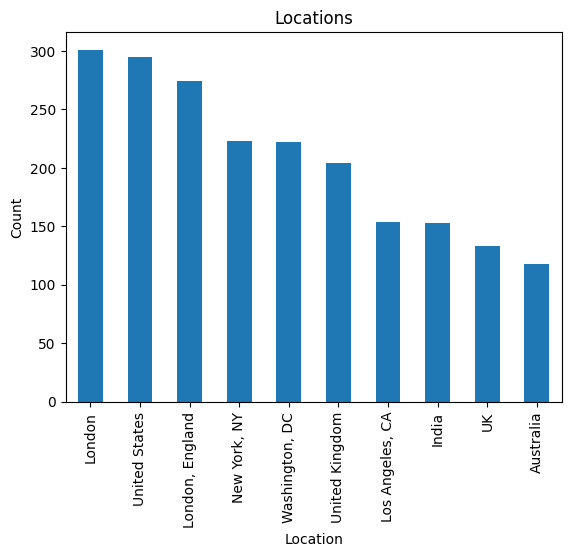

In [ ]:
train['Location'].value_counts()[1:11].plot.bar()

plt.ylabel("Count")
plt.title("Locations");

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
train['Location'][:10]

25621                Unknown
30135          Boston, MA HQ
28899                  India
5989     Mayfair, London, UK
4367                     WNC
21350      Ellicott City, MD
15378                Unknown
26258          United States
11184            Bedford, UK
5104                 Unknown
Name: Location, dtype: object

In [ ]:
# -- YOUR CODE HERE --
train['WiderLocation'] = train['Location'].apply(func=lambda x: x.split(", ")[-1])

In [ ]:
test['WiderLocation'] = test['Location'].apply(func=lambda x: x.split(", ")[-1])

In [ ]:
train['WiderLocation'][:10]

25621          Unknown
30135            MA HQ
28899            India
5989                UK
4367               WNC
21350               MD
15378          Unknown
26258    United States
11184               UK
5104           Unknown
Name: WiderLocation, dtype: object

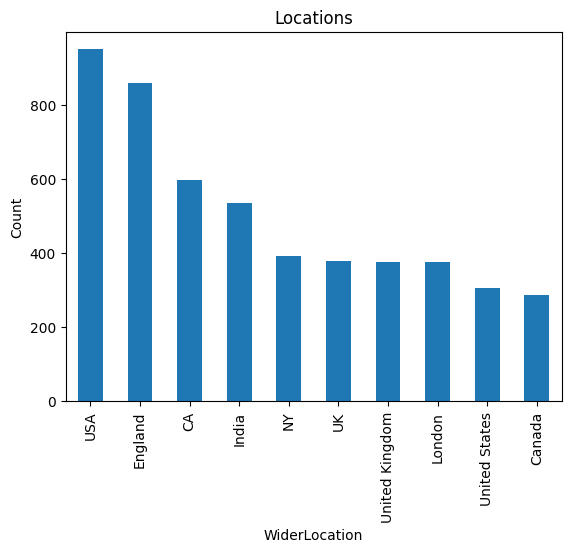

In [ ]:
train['WiderLocation'].value_counts()[1:11].plot.bar()
plt.ylabel("Count")
plt.title("Locations");

In [ ]:
train['WiderLocation'].unique().shape

(4921,)

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --
from sklearn.preprocessing import OneHotEncoder


cnt = train['WiderLocation'].value_counts()
train['LocationCount'] = train['WiderLocation'].apply(lambda x: cnt[x])
ind = train[train['LocationCount'] > 1]['WiderLocation'].unique()

enc = OneHotEncoder(categories=[ind], handle_unknown='ignore')

encoded_data = enc.fit_transform(train['WiderLocation'].values.reshape(-1, 1))

# enc.fit(train[])

In [ ]:
encoded_test = enc.fit_transform(test['WiderLocation'].values.reshape(-1, 1))

In [ ]:
encoded_data.toarray().shape

(23410, 1010)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
scaled_train = np.append(scaled_train, encoded_data.toarray().reshape(encoded_data.shape), axis=1)

In [ ]:
scaled_test = np.append(scaled_test, encoded_test.toarray().reshape(encoded_test.shape), axis=1)

In [ ]:
final_lr = LogisticRegression(max_iter=400)

final_lr.fit(scaled_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, final_lr.predict(scaled_train))}")
print(f"test accuracy: {accuracy_score(y_test, final_lr.predict(scaled_test))}")

train accuracy: 0.9453225117471166
test accuracy: 0.8448275862068966


**Ответ:** Точность осталась такой же, как и до добавления признаков с локацией

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.loc[(df['Sentiment'] == 'Positive') | (df['Sentiment'] == 'Extremely Positive'), 'Sentiment'] = 1
df.loc[(df['Sentiment'] == 'Negative') | (df['Sentiment'] == 'Extremely Negative'), 'Sentiment'] = 0

# df = df.drop(['UserName',	'ScreenName',	'Location',	'TweetAt'], axis=1)

train, test = train_test_split(df, train_size=0.7, random_state=0, stratify=df['Sentiment'])

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
20012,28197,73149,NaN,26-03-2020,"? New Podcast! ""Businesses Answering the COVID...",1
28328,38537,83489,"Whangarei, New Zealand",08-04-2020,Covid 19 coronavirus: Hundreds request virus c...,1
16192,23512,68464,NaN,24-03-2020,@Crohnoid @ChachyOwen @IBDPassport @J9JSM @vik...,1
31977,43130,88082,Canada ????? Edmonton,12-04-2020,@irSkullBeard @aseip1 Are social determinants ...,0
11431,17656,62608,"Butte, Montana",21-03-2020,As factories are stilled around the globe beca...,0


In [ ]:
train['OriginalTweet'].isna().any()

False

In [ ]:
y_train, y_test = train['Sentiment'].astype('int'), test['Sentiment'].astype('int')

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer

def custom_stem_tokenizer(text):
  # -- YOUR CODE HERE --
  #stemmer = SnowballStemmer("english")
  #text = text.lower()
  # stop = set(punctuation).union(set(stopwords.words("english")))
  tokens = [
      word
      for word in TweetTokenizer().tokenize(text)
      if (len(word) != 1 or ord(word) < 128) and
      # word not in stop and
      not word.startswith('http://t.co') and
      not "@" in word and
      not "#" in word
  ]

  return tokens

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.08, min_df=0.00005)

X_train = cv.fit_transform(train['OriginalTweet'])
X_test = cv.transform(test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
lr_cv = LogisticRegression(max_iter=350, C=0.75)

lr_cv.fit(X_train, y_train)

print("cv:")
print(f"train accuracy: {accuracy_score(y_train, lr_cv.predict(X_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr_cv.predict(X_test))}")

cv:
train accuracy: 0.9687313114053823
test accuracy: 0.8870839146900538


0.887

In [ ]:
def extract_features(text):
    words = set(custom_stem_tokenizer(text))
    features = {word: (word in words) for word in words}
    return features

In [ ]:
from nltk.classify import NaiveBayesClassifier

nb_train = [(extract_features(features), target) for (features, target) in zip(train['OriginalTweet'], y_train)]
nb_test = [(extract_features(features), target) for (features, target) in zip(test['OriginalTweet'], y_test)]

model = NaiveBayesClassifier.train(nb_train)

accuracy = nltk.classify.util.accuracy(model, nb_test)

print("Accuracy:", accuracy)

Accuracy: 0.8010763404424955


In [ ]:
mas_df = [0.00001, 0.00005, 0.0001, 0.001]

for mn_df in mas_df:
  cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=mn_df)

  X_train = cv.fit_transform(train['OriginalTweet'])
  X_test = cv.transform(test['OriginalTweet'])

  lr_cv = LogisticRegression(max_iter=350)

  lr_cv.fit(X_train, y_train)

  print(f"min_df = {mn_df}")
  print(f"train accuracy: {accuracy_score(y_train, lr_cv.predict(X_train))}")
  print(f"test accuracy: {accuracy_score(y_test, lr_cv.predict(X_test))}")
  print("==========================")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df = 1e-05
train accuracy: 0.9659974369927381
test accuracy: 0.8833964520629859


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df = 5e-05
train accuracy: 0.9586074327210594
test accuracy: 0.8836954355192346


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df = 0.0001
train accuracy: 0.9549765057667663
test accuracy: 0.88319712975882


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df = 0.001
train accuracy: 0.9155489107219137
test accuracy: 0.8706398245963723


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00005)

X_train = tfidf.fit_transform(train['OriginalTweet'])
X_test = tfidf.transform(test['OriginalTweet'])

lr_tfidf = LogisticRegression(max_iter=350)

lr_tfidf.fit(X_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, lr_tfidf.predict(X_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr_tfidf.predict(X_test))}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train accuracy: 0.9258436565570269
test accuracy: 0.7553318716364361


In [ ]:
len(stopwords.words('english'))

179

In [ ]:
cv = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    min_df=0.00005,
    stop_words=stopwords.words('english')[:len(stopwords.words('english')) // 4]
)

X_train = cv.fit_transform(train['OriginalTweet'])
X_test = cv.transform(test['OriginalTweet'])

lr_cv = LogisticRegression(max_iter=350)

lr_cv.fit(X_train, y_train)

print("cv:")
print(f"train accuracy: {accuracy_score(y_train, lr_cv.predict(X_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr_cv.predict(X_test))}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ourselv', 'themselv', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(


cv:
train accuracy: 0.9582656984194788
test accuracy: 0.8841937412796492


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
prev = 0
for i in range(6):
  end = min(179, prev + 30)
  stop = stopwords.words('english')[prev:end]
  # print(f'{prev} : {end}')

  cv = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    min_df=0.00005,
    stop_words=stop
  )

  X_train = cv.fit_transform(train['OriginalTweet'])
  X_test = cv.transform(test['OriginalTweet'])

  lr_cv = LogisticRegression(max_iter=350)

  lr_cv.fit(X_train, y_train)

  print(f'{prev} : {end}')
  print(f"train accuracy: {accuracy_score(y_train, lr_cv.predict(X_train))}")
  print(f"test accuracy: {accuracy_score(y_test, lr_cv.predict(X_test))}")
  print("====================")

  prev += 30


0 : 30
train accuracy: 0.9586928662964546
test accuracy: 0.884393063583815
30 : 60
train accuracy: 0.9577530969671081
test accuracy: 0.8824995016942396
60 : 90
train accuracy: 0.9581375480563862
test accuracy: 0.8826988239984054
90 : 120
train accuracy: 0.9548483554036736
test accuracy: 0.8745266095276062
120 : 150
train accuracy: 0.9583938487825715
test accuracy: 0.8839944189754834
150 : 179
train accuracy: 0.9568987612131568
test accuracy: 0.8818018736296591


In [ ]:
cv = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    min_df=0.00005,
    stop_words=stopwords.words('english')[:90]
)

X_train = cv.fit_transform(train['OriginalTweet'])
X_test = cv.transform(test['OriginalTweet'])

lr_cv = LogisticRegression(max_iter=350)

lr_cv.fit(X_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, lr_cv.predict(X_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr_cv.predict(X_test))}")
print("====================")

train accuracy: 0.9586074327210594
test accuracy: 0.8836954355192346


0.883

In [ ]:
punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
cv = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    min_df=0.00005,
    # stop_words=stopwords.words('english')[:90]
)

X_train = cv.fit_transform(train['OriginalTweet'])
X_test = cv.transform(test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
lr_cv = LogisticRegression(max_iter=350, C=0.7)

lr_cv.fit(X_train, y_train)

print(f"train accuracy: {accuracy_score(y_train, lr_cv.predict(X_train))}")
print(f"test accuracy: {accuracy_score(y_test, lr_cv.predict(X_test))}")
print("====================")

train accuracy: 0.9530115335326783
test accuracy: 0.8837950966713175
